In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020522,2025-12-17T00:00:00,Detroit Red Wings,New York Islanders,0.5460,0.4406,0.7686,3,2,True,False,True
1,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          616      0.5325 0.2540   0.7014 0.5134   0.5211
Totals (Over/Under)  616      0.4708 0.2498   0.6927 0.5199   0.5227
Asian Handicap       616      0.7484 0.1898   0.5676 0.5469   0.7468


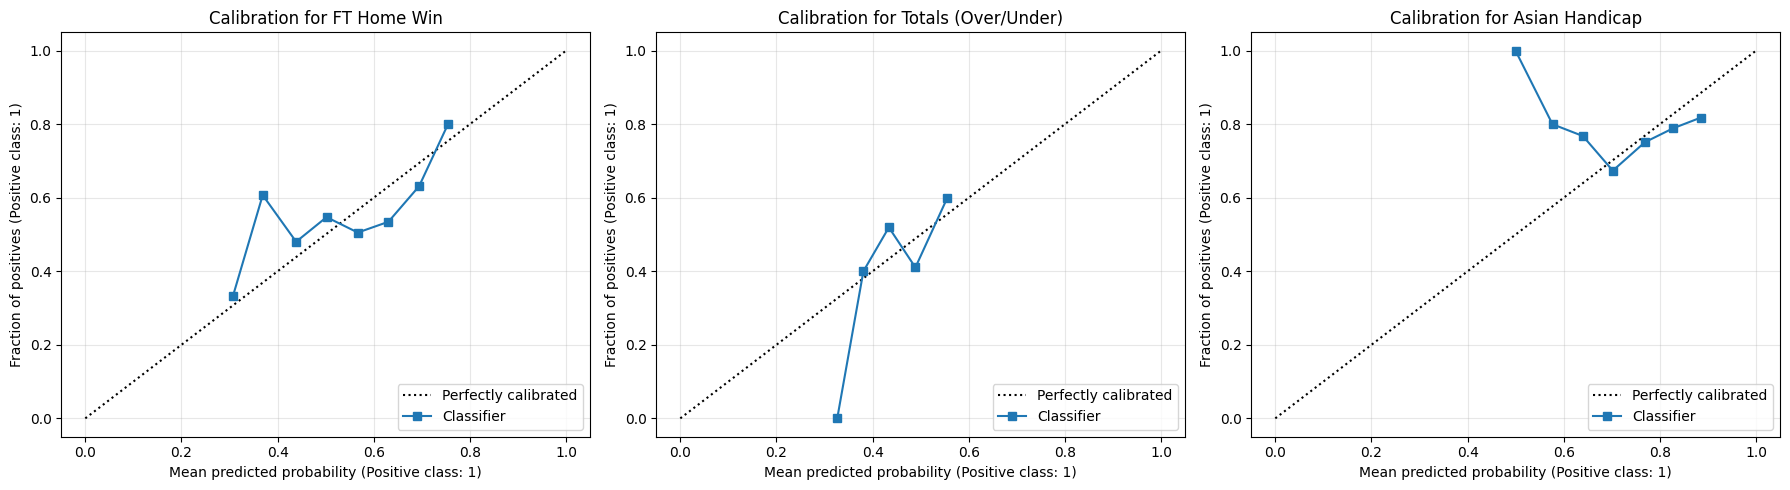

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          476      0.5336 0.2521   0.6972 0.5225   0.5210
Totals (Over/Under)  476      0.4706 0.2496   0.6924 0.5272   0.5126
Asian Handicap       476      0.7458 0.1913   0.5701 0.5457   0.7437


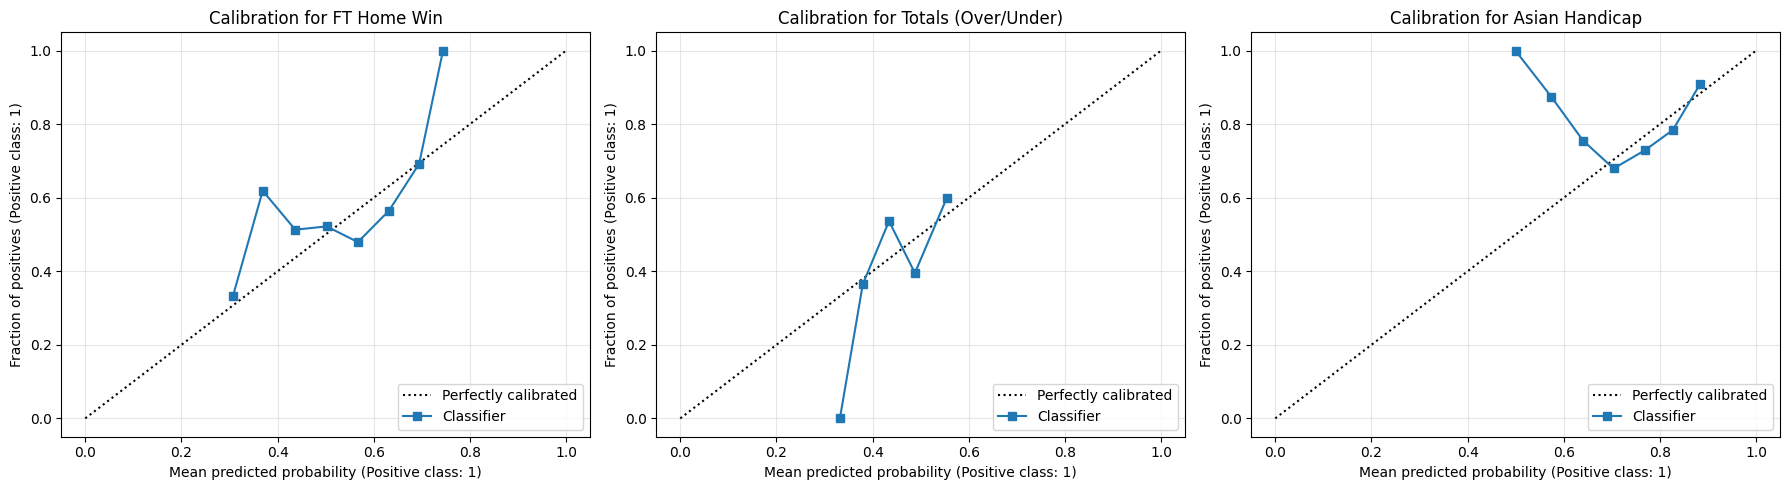

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500521,2026-01-08T00:30:00,Brooklyn Nets,Orlando Magic,0.7966,0.5374,0.9183,103,104,False,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          330      0.5545 0.2337   0.6624 0.6522   0.6182
Totals (Over/Under)  330      0.5758 0.2546   0.7104 0.6004   0.5758
Asian Handicap       330      0.7545 0.1738   0.5232 0.6830   0.7455


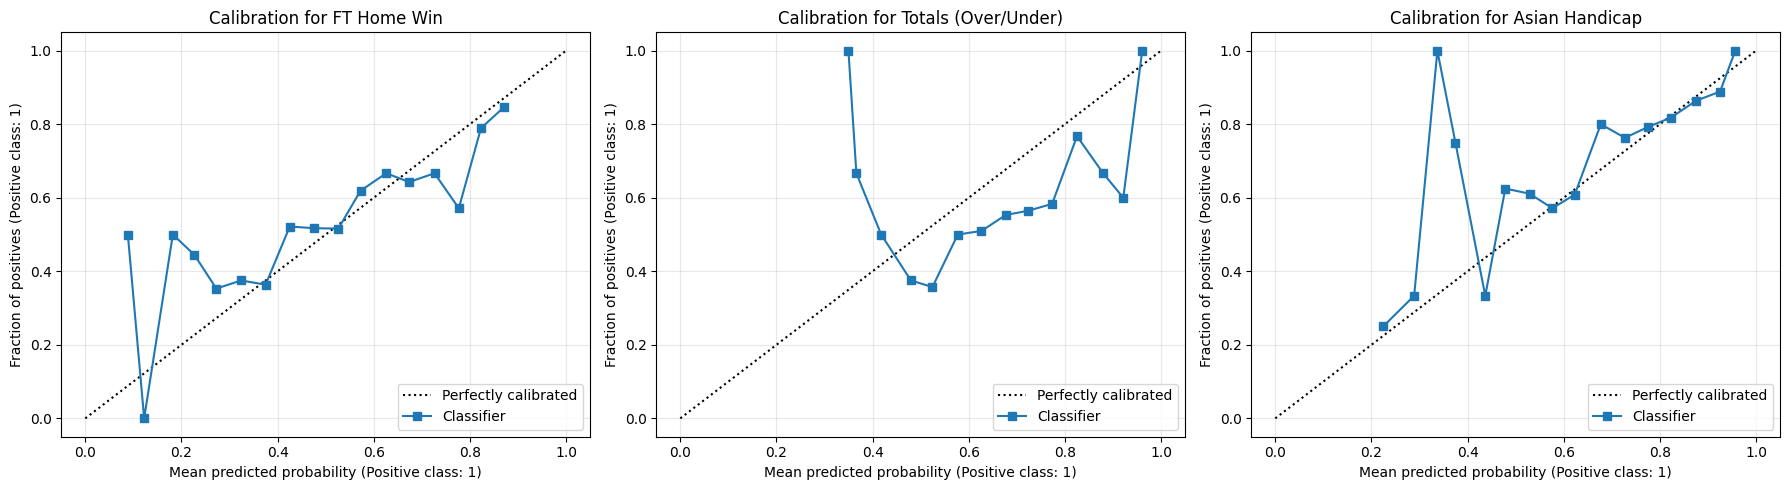

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)